In [4]:
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
import os
from tqdm import tqdm_notebook as tqdm

from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.utils import plot_some, plot_history
from csbdeep.data import RawData, create_patches
from csbdeep.io import load_training_data
from .networks import segnet

ImportError: attempted relative import with no known parent package

In [2]:
limit_gpu_memory(fraction=2/3)

In [ ]:
base_dir = 'path/to/image/dir'
train_dir = os.path.join(base_dir, 'trainImages')
label_dir = os.path.join(base_dir, 'trainLabels')

In [ ]:
imgList = os.listdir(train_dir)
labelList = os.listdir(label_dir)

imgArray = []
for image in tqdm(imgList, 'Reading img'):
    imgArray.append(imread(os.path.join(train_dir, image)))

labelArray = []
for label in tqdm(labelList, 'Reading label'):
    labelArray.append(imread(os.path.join(label_dir, label)))

In [ ]:
print(imgArray[0].shape)
print(labelArray[0].shape)

In [ ]:
raw_data = RawData.from_arrays(
    imgArray,
    labelArray,
    axes='YX'
)

In [ ]:
X, Y, XY_axes = create_patches(
    raw_data=raw_data,
    patch_size=(128, 128, 1),
    patch_axes='YXC',
    n_patches_per_image=25,
    save_file='/mydata.npz'
)

In [3]:
(X, Y), (X_val, Y_val), axes = load_training_data(
    '/mydata.npz',
    validation_split=0.1,
    verbose=True
)

number of training images:	 10327
number of validation images:	 1148
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 1 / 1


(10327, 128, 128, 1)
(128, 128, 1)


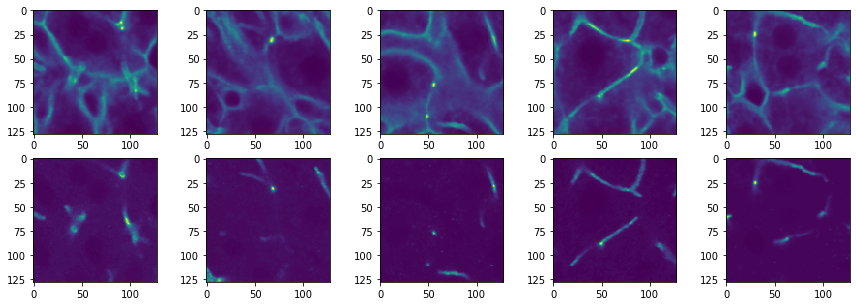

In [4]:
print(X.shape)
n = 10
print(X[n].shape)
fig = plt.figure(figsize=(15,5))
pl1_x = fig.add_subplot(2, 5, 1)
pl1_x.imshow(X[n][...,0])
pl1_y = fig.add_subplot(2, 5, 6)
pl1_y.imshow(Y[n][...,0])
pl2_x = fig.add_subplot(2, 5, 2)
pl2_x.imshow(X[n+1][...,0])
pl2_y = fig.add_subplot(2, 5, 7)
pl2_y.imshow(Y[n+1][...,0])
pl3_x = fig.add_subplot(2, 5, 3)
pl3_x.imshow(X[n+2][...,0])
pl3_y = fig.add_subplot(2, 5, 8)
pl3_y.imshow(Y[n+2][...,0])
pl4_x = fig.add_subplot(2, 5, 4)
pl4_x.imshow(X[n+3][...,0])
pl4_y = fig.add_subplot(2, 5, 9)
pl4_y.imshow(Y[n+3][...,0])
pl5_x = fig.add_subplot(2, 5, 5)
pl5_x.imshow(X[n+4][...,0])
pl5_y = fig.add_subplot(2, 5, 10)
pl5_y.imshow(Y[n+4][...,0])

In [5]:
#opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
sgd = SGD(lr=0.0001, momentum=0.9, nesterov=False)

model = segnet(input_shape=(128, 128, 1), conv_kernel_size=3, dropout=0.5, filters=64, last_activation='softmax')
model.compile(optimizer=sgd, loss='binary_crossentropy')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
acti

In [6]:
history = model.fit(
    X,
    Y,
    batch_size=16,
    epochs=3,
    validation_data=(X_val, Y_val),
    shuffle=True,
    validation_freq=1
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 10327 samples, validate on 1148 samples
Epoch 1/3
10327/10327 [==============================] - 211s 20ms/step - loss: 14.7008 - val_loss: 14.7013
Epoch 2/3
10327/10327 [==============================] - 202s 20ms/step - loss: 14.7008 - val_loss: 14.7013
Epoch 3/3
10327/10327 [==============================] - 206s 20ms/step - loss: 14.7008 - val_loss: 14.7013


['loss', 'val_loss']


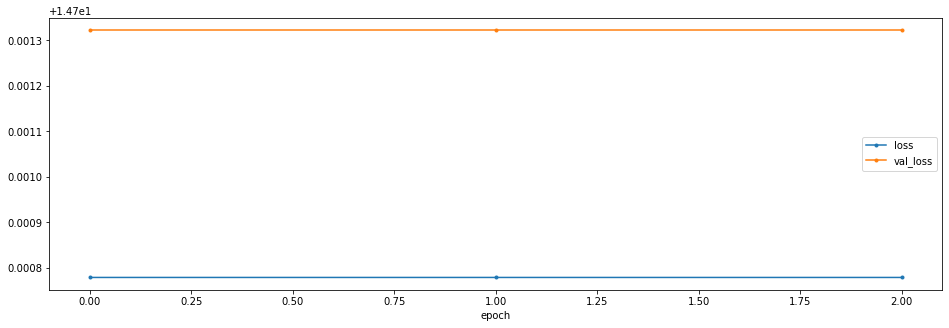

In [7]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history, ['loss', 'val_loss'])

In [8]:
model.save('mysegnet.h5')